# Supervised CARE Training

Here we use CARE training using noisy images as input and averaged noisy images as target.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ppn2v.unet import UNet
from ppn2v.pn2v import utils

from ppn2v.pn2v import training
from tifffile import imread
# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Download data
Download the data from https://zenodo.org/record/5156960/files/Mouse%20skull%20nuclei.zip?download=1. Here we show the pipeline for Mouse skull nuclei dataset. Load the appropriate dataset at an appropriate path. For us, the path is data folder which exists at `../../../`. For Mouse skull nuclei, the data to be denoised is named ```example2_digital_offset300.tif```. 

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data/Mouse skull nuclei'):
    os.mkdir('../../../data/Mouse skull nuclei')

zipPath="../../../data/Mouse_skull_nuclei.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve(' https://zenodo.org/record/5156960/files/Mouse%20skull%20nuclei.zip?download=1', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data/Mouse skull nuclei")


### Load Data
#### Ensure ```filename = example2_digital_offset300.tif``` and specify the ```dataname```  

In [5]:
path='../../../data/Mouse skull nuclei/Mouse skull nuclei/'
fileName='example2_digital_offset300.tif'
dataName='mouseskullnuclei' # This will be used to name the care model

#### Noisy Data (Input to network)

In [6]:
data=imread(path+fileName)
nameModel=dataName+'_care'

#### Ground truth Data (Target of Network)

In [7]:
dataGT = np.mean(data, axis=0)[np.newaxis,...,np.newaxis]

In [8]:
data=data[...,np.newaxis]
dataGT = np.repeat(dataGT, 200, axis=0)
print("Shape of Raw Noisy Image is ", data.shape, "; Shape of Target Image is ", dataGT.shape)
data = np.concatenate((data,dataGT),axis=-1)
# Add the target image as a second channel to `data`
print("Shape of `data` is ", data.shape)

Shape of Raw Noisy Image is  (200, 512, 512, 1) ; Shape of Target Image is  (200, 512, 512, 1)
Shape of `data` is  (200, 512, 512, 2)


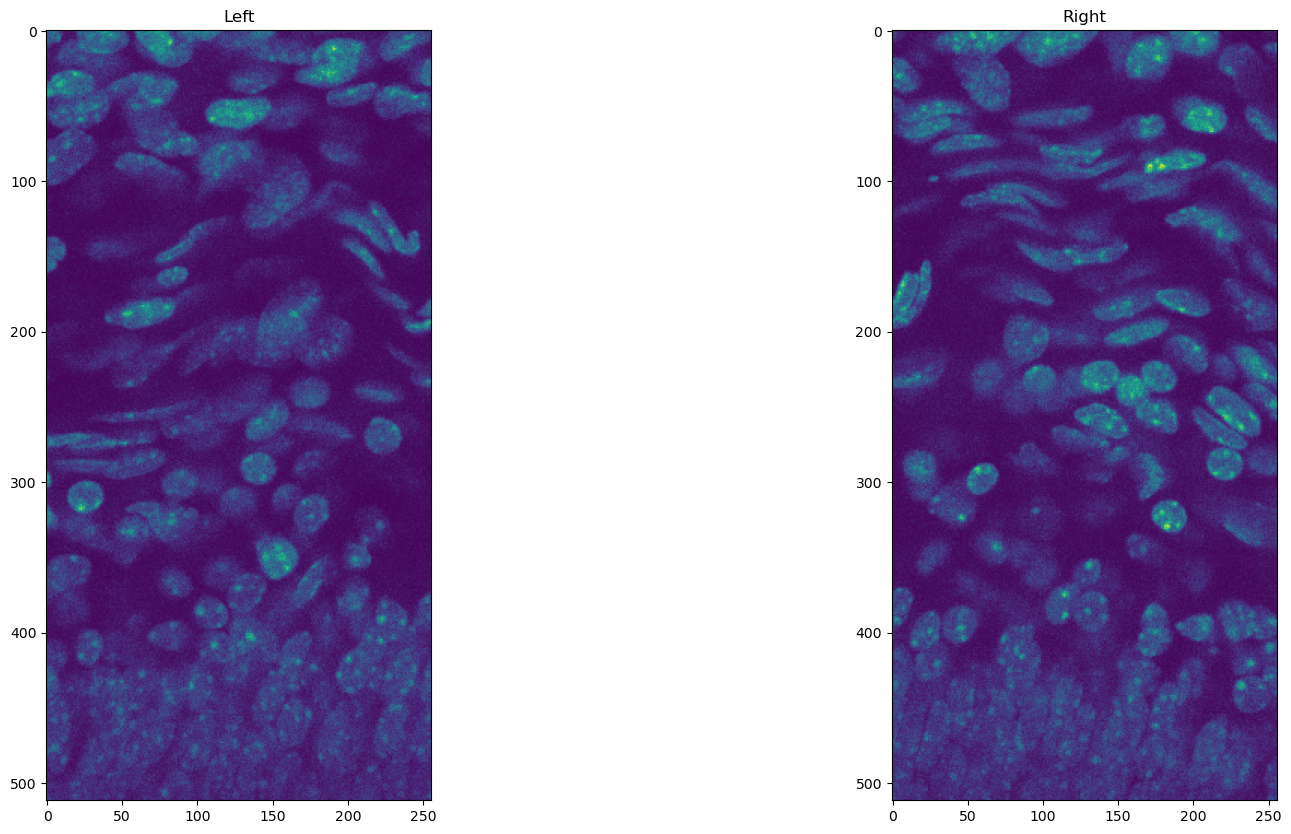

In [9]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(data[0,:,:256,0])
plt.title('Left')

plt.subplot(1,2,2)
plt.imshow(data[0,:,256:,0])
plt.title('Right')

plt.show()

# We now crop away the left portion of the data since this portion will be used later for testing
data = data[:, :, 256:, :]

### Create the Network and Train it
This can take a while.

In [10]:
# The CARE network requires only a single output unit per pixel
net = UNet(1, depth=3)

# Split training and validation data.
my_train_data=data[:-5].copy()
my_val_data=data[-5:].copy()

# Start training.
trainHist, valHist = training.trainNetwork(net=net, trainData=my_train_data, valData=my_val_data,
                                           postfix=nameModel, directory=path, noiseModel=None,
                                           device=device, numOfEpochs= 200, stepsPerEpoch=5, 
                                           virtualBatchSize=20, batchSize=1, learningRate=1e-3, supervised=True)

/home/mehdi.seifi/miniconda3/envs/ppn2v_test/lib/python3.9/site-packages/ppn2v/unet/model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/home/mehdi.seifi/miniconda3/envs/ppn2v_test/lib/python3.9/site-packages/ppn2v/unet/model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


Epoch 0 finished      
avg. loss: 0.3639302931725979+-(2SEM)0.0398552713360214      
Epoch 1 finished      
avg. loss: 0.074515400826931+-(2SEM)0.007486713577903817      
Epoch 2 finished      
avg. loss: 0.04462679494172335+-(2SEM)0.006517969340070657      
Epoch 3 finished      
avg. loss: 0.03632529601454735+-(2SEM)0.0049418136594037935      
Epoch 4 finished      
avg. loss: 0.03745100973173976+-(2SEM)0.005778018978783318      
Epoch 5 finished      
avg. loss: 0.02985509382560849+-(2SEM)0.004061570227562751      
Epoch 6 finished      
avg. loss: 0.029949769750237464+-(2SEM)0.003957339811317163      
Epoch 7 finished      
avg. loss: 0.024935283046215773+-(2SEM)0.0029379180669951363      
Epoch 8 finished      
avg. loss: 0.028030820097774266+-(2SEM)0.003771768271030147      
Epoch 9 finished      
avg. loss: 0.021544030914083124+-(2SEM)0.002590258693604683      
Epoch 10 finished      
avg. loss: 0.02366122673265636+-(2SEM)0.003051727360670022      
Epoch 11 finished      
avg. l

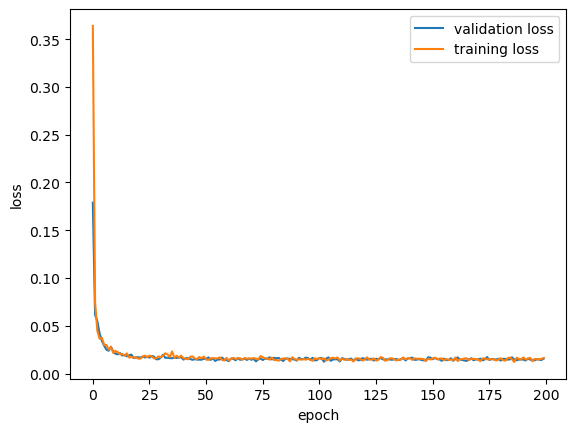

In [11]:
# Let's look at the training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(valHist, label='validation loss')
plt.plot(trainHist, label='training loss')
plt.legend()
plt.show()